In [1]:
from qubit_simulator import QubitSimulator
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [2]:
def true_prob(simulator: QubitSimulator):
    # Calculate true probabilities
    true_probabilities = np.abs(simulator.state_vector) ** 2
    # Print true probabilities
    for i, prob in enumerate(true_probabilities):
        print(f"{format(i, '03b')}: {prob}")


def test_qft(simulator: QubitSimulator, num_qubits: int):
    def apply_qft(simulator):
        num_qubits = simulator.num_qubits
        for target_qubit in range(num_qubits):
            simulator.h(target_qubit)
            for control_qubit in range(target_qubit + 1, num_qubits):
                phase_angle = 2 * np.pi / (2 ** (control_qubit - target_qubit + 1))
                simulator.cu(control_qubit, target_qubit, 0, -phase_angle, 0)
        # Swap qubits to match the desired output order
        for i in range(num_qubits // 2):
            j = num_qubits - i - 1
            simulator.cx(i, j)
            simulator.cx(j, i)
            simulator.cx(i, j)

    # Create a random initial state vector and normalize it
    random_state = np.random.rand(2**num_qubits) + 1j * np.random.rand(
        2**num_qubits
    )
    random_state /= np.linalg.norm(random_state)
    # Set the random state as the initial state in the simulator
    simulator.state_vector = random_state.copy()
    # Apply QFT in the simulator
    apply_qft(simulator)
    # Compute the expected result using NumPy's FFT and normalize
    fft_result = np.fft.fft(random_state) / np.sqrt(2**num_qubits)
    # Compare the state vectors
    assert np.allclose(simulator.state_vector, fft_result)

In [3]:
class QubitSimulator2(QubitSimulator):
    def plot_wavefunction(self):
        """
        Plots the wave function with amplitude and phase.
        """
        # Get the amplitudes and phases
        amplitudes = np.abs(self.state_vector)
        phases = np.angle(self.state_vector)
        # Create the figure and axis objects
        fig, ax1 = plt.subplots()
        # Plot amplitudes
        ax1.bar(range(len(amplitudes)), amplitudes)
        ax1.set_ylabel("Amplitude")
        ax1.set_xlabel("Basis State")
        ax1.set_title("Wave Function Amplitude and Phase")
        # Create a second y-axis to plot phases
        ax2 = ax1.twinx()
        ax2.plot(range(len(phases)), phases, "ro-")
        ax2.set_ylabel("Phase (radians)")
        plt.xticks(
            range(len(phases)),
            [format(i, f"0{self.num_qubits}b") for i in range(len(phases))],
            rotation=90,
        )
        plt.show()

    def run(self, shots: int = 100, basis: np.ndarray = None) -> dict:
        """
        Runs the simulation and returns measurement results.

        :param shots: Number of measurements.
        :param basis: Optional basis transformation.
        :return: Dictionary of measurement results.
        """
        if shots < 0:
            raise ValueError("Number of shots must be non-negative.")
        state_vector = self.state_vector if basis is None else basis @ self.state_vector
        # Compute probabilities from the state vector
        probabilities = np.abs(state_vector) ** 2
        # Multiply probabilities by shots and round to integers
        counts = np.round(probabilities * shots).astype(int)
        # Convert outcomes to binary strings
        result_counts = {
            format(outcome, f"0{self.num_qubits}b"): count
            for outcome, count in enumerate(counts)
            if count > 0
        }
        return result_counts

In [4]:
class QubitSimulator3(QubitSimulator):
    def plot_wavefunction(self):
        """
        Plots the amplitude and phase of each state in the state vector.
        """
        states = [format(i, f'0{self.num_qubits}b') for i in range(2 ** self.num_qubits)]
        amplitudes = np.abs(self.state_vector)
        phases = np.angle(self.state_vector)
        fig, ax1 = plt.subplots()
        # Plot amplitude as bars
        ax1.bar(states, amplitudes, alpha=0.6, label='Amplitude')
        # Create a second y-axis to plot phase
        ax2 = ax1.twinx()
        ax2.scatter(states, phases, color='r', label='Phase')
        # Labels and title
        ax1.set_xlabel('States')
        ax1.set_ylabel('Amplitude', color='b')
        ax2.set_ylabel('Phase', color='r')
        plt.title('Amplitude and Phase')
        # Show legend
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        plt.show()

In [5]:
class QubitSimulator4(QubitSimulator):
    def plot_wavefunction(self):
        """
        Plots the wavefunction's amplitude and phase using a phase circle plot.
        """
        # Get the amplitude and phase
        amplitude = np.abs(self.state_vector)
        phase = np.angle(self.state_vector)
        # Generate labels for each state
        labels = [format(i, f"0{self.num_qubits}b") for i in range(len(self.state_vector))]
        # Create a plot
        fig, ax = plt.subplots()
        ax.set_aspect("equal", "box")
        # Plot each state's amplitude and phase
        for i, (amp, phi) in enumerate(zip(amplitude, phase)):
            x = amp * np.cos(phi)
            y = amp * np.sin(phi)
            ax.scatter(x, y)
            ax.annotate(
                labels[i],
                (x, y),
                textcoords="offset points",
                xytext=(0, 10),
                ha="center",
            )
        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-1.1, 1.1)
        ax.axhline(0, color="black", linewidth=0.5)
        ax.axvline(0, color="black", linewidth=0.5)
        plt.title('Amplitude and Phase of Quantum States')
        plt.xlabel('Real Component (Cosine of Phase * Amplitude)')
        plt.ylabel('Imaginary Component (Sine of Phase * Amplitude)')
        plt.show()

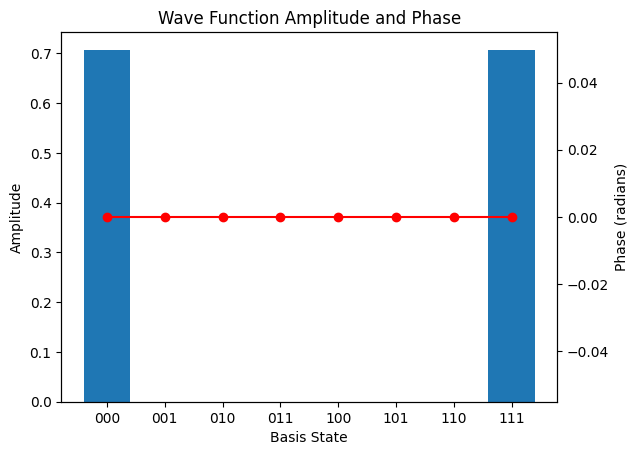

In [6]:
num_qubits = 3
simulator = QubitSimulator2(num_qubits)
simulator.h(0)
simulator.cx(0, 1)
simulator.cx(0, 2)

simulator.plot_wavefunction()

----------------------------------------------------------------------------------------------
| H | U(0.00, -1.57, 0.00) | U(0.00, -0.79, 0.00) |   |                      |   | @ | X | @ |
|   |          @           |                      | H | U(0.00, -1.57, 0.00) |   |   |   |   |
|   |                      |          @           |   |          @           | H | X | @ | X |
----------------------------------------------------------------------------------------------
{'000': 84, '011': 3, '100': 5, '101': 2, '110': 3, '111': 1}


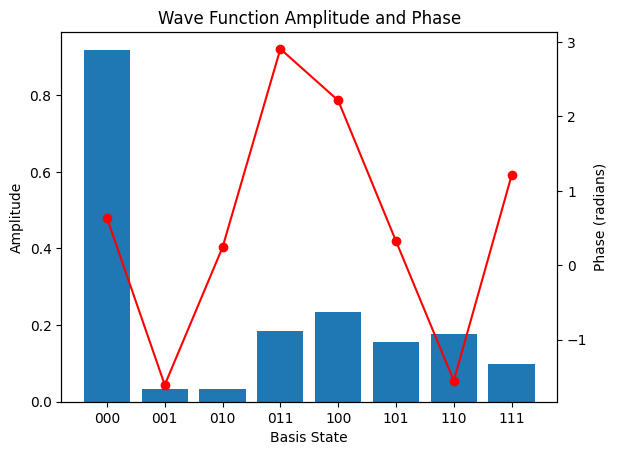

In [7]:
num_qubits = 3
simulator = QubitSimulator2(num_qubits)
test_qft(simulator, num_qubits)

print(simulator)
print(simulator.run(100))
simulator.plot_wavefunction()

----------------------------------------------------------------------------------------------
| H | U(0.00, -1.57, 0.00) | U(0.00, -0.79, 0.00) |   |                      |   | @ | X | @ |
|   |          @           |                      | H | U(0.00, -1.57, 0.00) |   |   |   |   |
|   |                      |          @           |   |          @           | H | X | @ | X |
----------------------------------------------------------------------------------------------
{'000': 87, '111': 3, '011': 4, '101': 2, '010': 1, '100': 2, '001': 1}


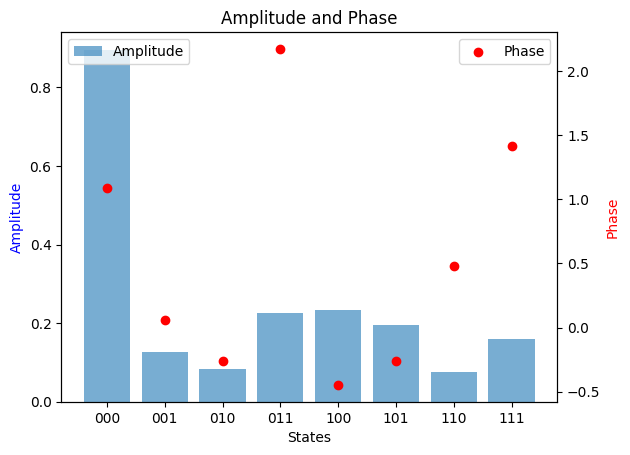

In [8]:
num_qubits = 3
simulator = QubitSimulator3(num_qubits)
test_qft(simulator, num_qubits)

print(simulator)
print(simulator.run(100))
simulator.plot_wavefunction()

--------------------------------------------
| H | U(0.00, -1.57, 0.00) |   | @ | X | @ |
|   |          @           | H | X | @ | X |
--------------------------------------------
{'00': 70, '11': 6, '01': 7, '10': 17}
000: 0.7503925062554346
001: 0.04552705768546913
010: 0.12903776136718362
011: 0.07504267469191231


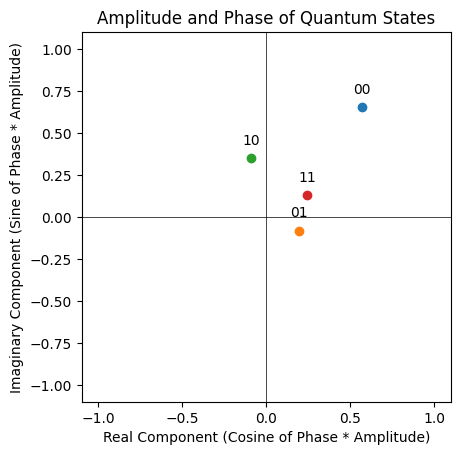

In [9]:
num_qubits = 2
simulator = QubitSimulator4(num_qubits)
test_qft(simulator, num_qubits)

print(simulator)
print(simulator.run(100))
true_prob(simulator)
simulator.plot_wavefunction()